In [1]:
import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [2]:
from afr3d.io.step_import import load_step
from afr3d.drafting.views import select_main_views, build_linear_view, extract_solids
from afr3d.features import analyze_part
from afr3d.drafting.analytic import build_analytic_view_from_topology
from afr3d.drafting.circles import rebuild_circles_from_hlr_analytic
from afr3d.drafting.model import DraftView2D

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from afr3d.drafting.model import DraftView2D, DraftCurveKind

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="OCC")

In [3]:
shape_raw = load_step("../data/example_complex.stp")
shape = extract_solids(shape_raw)

In [4]:
part_analysis = analyze_part(shape)   # как у тебя в CLI
holes_afr = part_analysis.holes      # список HoleAFR

view_set = select_main_views(shape)

In [5]:
# HLR front
front_segs = build_linear_view(shape, view_set.front.ax2)

# Аналитический front
front_analytic = build_analytic_view_from_topology(shape, view_set.front.ax2, name="front_analytic")

# Аналитический front + идеальные круги для отверстий
front_with_holes = rebuild_circles_from_hlr_analytic(front_analytic, holes_afr)

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from afr3d.drafting.model import DraftView2D, DraftCurveKind

def plot_draft_view_edges_and_circles(ax, view: DraftView2D, title: str = ""):
    # словарь id -> вершина
    vmap = {v.id: v for v in view.vertices}

    # Рёбра (линейные)
    for e in view.edges:
        v1 = vmap.get(e.v_start)
        v2 = vmap.get(e.v_end)
        if v1 is None or v2 is None:
            continue
        ax.plot([v1.x, v2.x], [v1.y, v2.y], "-", linewidth=0.6)

    # Аналитические кривые: пока рисуем только окружности
    for c in view.curves:
        if c.kind == DraftCurveKind.CIRCLE and c.center is not None and c.radius is not None:
            cx, cy = c.center
            R = c.radius
            circ = Circle((cx, cy), R, fill=False, linewidth=0.8)
            ax.add_patch(circ)

    # Настройки
    ax.set_aspect("equal", "box")
    ax.invert_yaxis()
    ax.set_title(title)
    ax.grid(True, linestyle=":", linewidth=0.3)

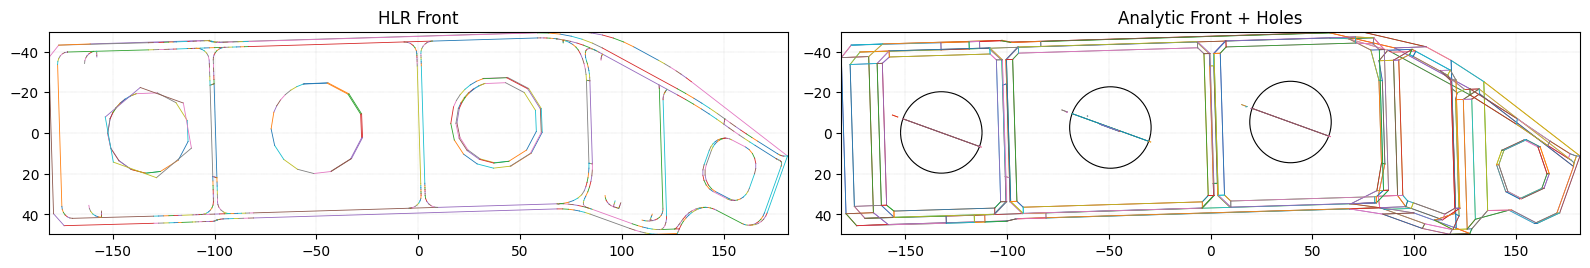

In [7]:
def get_bounds_segments(segments):
    xs, ys = [], []
    for s in segments:
        xs.extend([s.x1, s.x2])
        ys.extend([s.y1, s.y2])
    return min(xs), max(xs), min(ys), max(ys)

def get_bounds_view(view: DraftView2D):
    xs, ys = [], []
    for v in view.vertices:
        xs.append(v.x)
        ys.append(v.y)
    for c in view.curves:
        if c.kind == DraftCurveKind.CIRCLE and c.center is not None and c.radius is not None:
            cx, cy = c.center
            R = c.radius
            xs.extend([cx - R, cx + R])
            ys.extend([cy - R, cy + R])
    if not xs:
        return 0, 1, 0, 1
    return min(xs), max(xs), min(ys), max(ys)

# Общие границы для сопоставления масштаба
min_x1, max_x1, min_y1, max_y1 = get_bounds_segments(front_segs)
min_x2, max_x2, min_y2, max_y2 = get_bounds_view(front_with_holes)

min_x = min(min_x1, min_x2)
max_x = max(max_x1, max_x2)
min_y = min(min_y1, min_y2)
max_y = max(max_y1, max_y2)

def apply_bounds(ax):
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(max_y, min_y)  # инверсия Y

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Левый — HLR
for s in front_segs:
    axes[0].plot([s.x1, s.x2], [s.y1, s.y2], "-", linewidth=0.6)
axes[0].set_aspect("equal", "box")
axes[0].invert_yaxis()
axes[0].set_title("HLR Front")
axes[0].grid(True, linestyle=":", linewidth=0.3)
apply_bounds(axes[0])

# Правый — аналитический (рёбра + окружности отверстий)
plot_draft_view_edges_and_circles(axes[1], front_with_holes, title="Analytic Front + Holes")
apply_bounds(axes[1])

plt.tight_layout()
plt.show()

In [8]:
from afr3d.drafting.views import generate_six_obb_views

views_6 = generate_six_obb_views(shape)

analytic_views = []
analytic_with_holes = []

for vdef in views_6:
    v_analytic = build_analytic_view_from_topology(shape, vdef.ax2, name=vdef.name)
    v_with_holes = rebuild_circles_from_hlr_analytic(v_analytic, holes_afr, angle_tol_deg=8.0)
    analytic_views.append(v_analytic)
    analytic_with_holes.append(v_with_holes)

In [9]:
def rotate_point_deg(x: float, y: float, angle_deg: float) -> tuple[float, float]:
    if angle_deg == 0:
        return x, y
    if angle_deg == 90:
        # поворот против часовой: (x, y) -> (-y, x)
        return -y, x
    if angle_deg == -90:
        # по часовой: (x, y) -> (y, -x)
        return y, -x
    if angle_deg == 180 or angle_deg == -180:
        return -x, -y

    # общий случай, если захочешь
    rad = math.radians(angle_deg)
    c = math.cos(rad)
    s = math.sin(rad)
    return c*x - s*y, s*x + c*y

VIEW_ROTATION = {
    "+d1": 0,      # фронт
    "-d1": 180,    # задний
    "+d2": 90,     # вид сверху (один вариант)
    "-d2": -90,    # вид снизу / обратный сверху
    "+d3": 90,     # вид слева/справа – подберёшь по вкусу
    "-d3": -90,
}

In [10]:
def plot_draft_view_edges_and_circles_and_rotation(ax, view: DraftView2D, title: str = ""):
    angle = VIEW_ROTATION.get(view.name, 0)

    vmap = {v.id: v for v in view.vertices}

    # Рёбра
    for e in view.edges:
        if not e.visible:
            continue
        v1 = vmap.get(e.v_start)
        v2 = vmap.get(e.v_end)
        if v1 is None or v2 is None:
            continue

        x1, y1 = rotate_point_deg(v1.x, v1.y, angle)
        x2, y2 = rotate_point_deg(v2.x, v2.y, angle)

        ax.plot([x1, x2], [y1, y2], "-", linewidth=0.6)

    # Круги
    for c in view.curves:
        if not c.visible:
            continue
        if c.kind == DraftCurveKind.CIRCLE and c.center is not None and c.radius is not None:
            cx, cy = c.center
            cxr, cyr = rotate_point_deg(cx, cy, angle)
            R = c.radius
            circ = Circle((cxr, cyr), R, fill=False, linewidth=0.8)
            ax.add_patch(circ)

    ax.set_aspect("equal", "box")
    ax.invert_yaxis()
    ax.set_title(title or view.name)
    ax.grid(True, linestyle=":", linewidth=0.3)


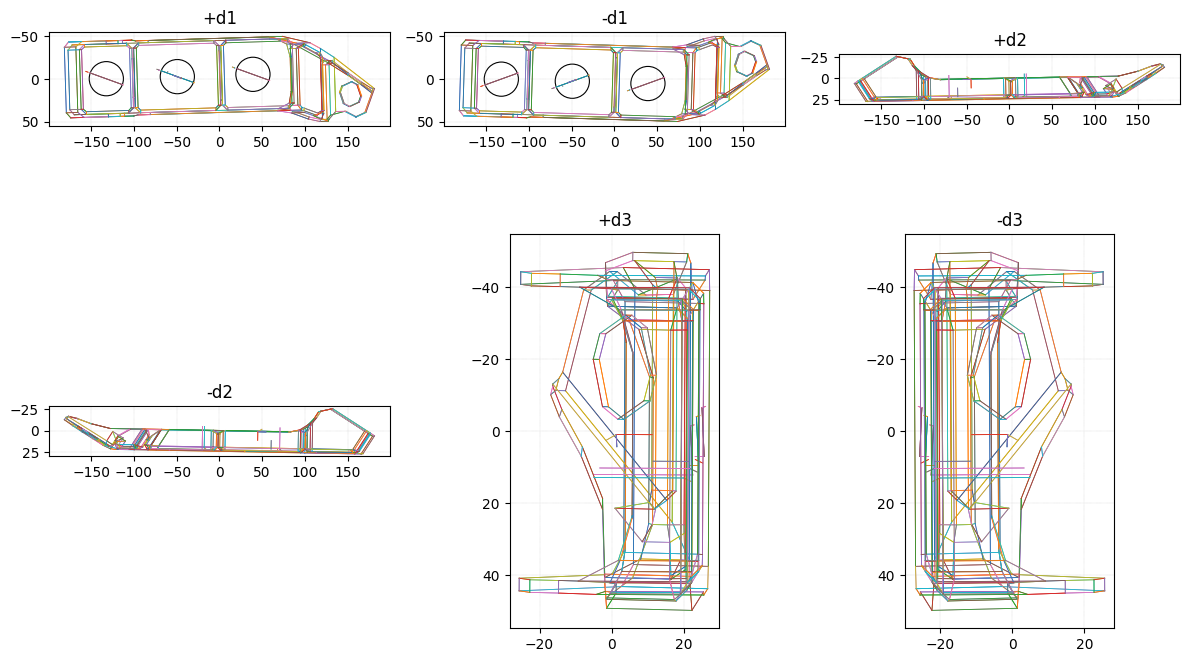

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (v, v_holes) in enumerate(zip(analytic_views, analytic_with_holes)):
    r, c = divmod(i, 3)
    ax = axes[r, c]
    plot_draft_view_edges_and_circles_and_rotation(ax, v_holes, title=v.name)

plt.tight_layout()
plt.show()

# добавляем все круги

In [12]:
from afr3d.drafting.circles import rebuild_all_circles

view_defs = generate_six_obb_views(shape)  # твоя функция по OBB
#vdef = view_defs[0]  # например, "+d1"
analytic_views = []
analytic_with_circles = []

for vdef in view_defs:
    analytic_view = build_analytic_view_from_topology(shape, vdef.ax2, name=vdef.name)
    analytic_views.append(analytic_view)
    analytic_with_circles.append(rebuild_all_circles(analytic_view, shape, holes_afr))

#plot_draft_view_edges_and_circles_and_rotation(ax, analytic_with_circles, title=vdef.name)

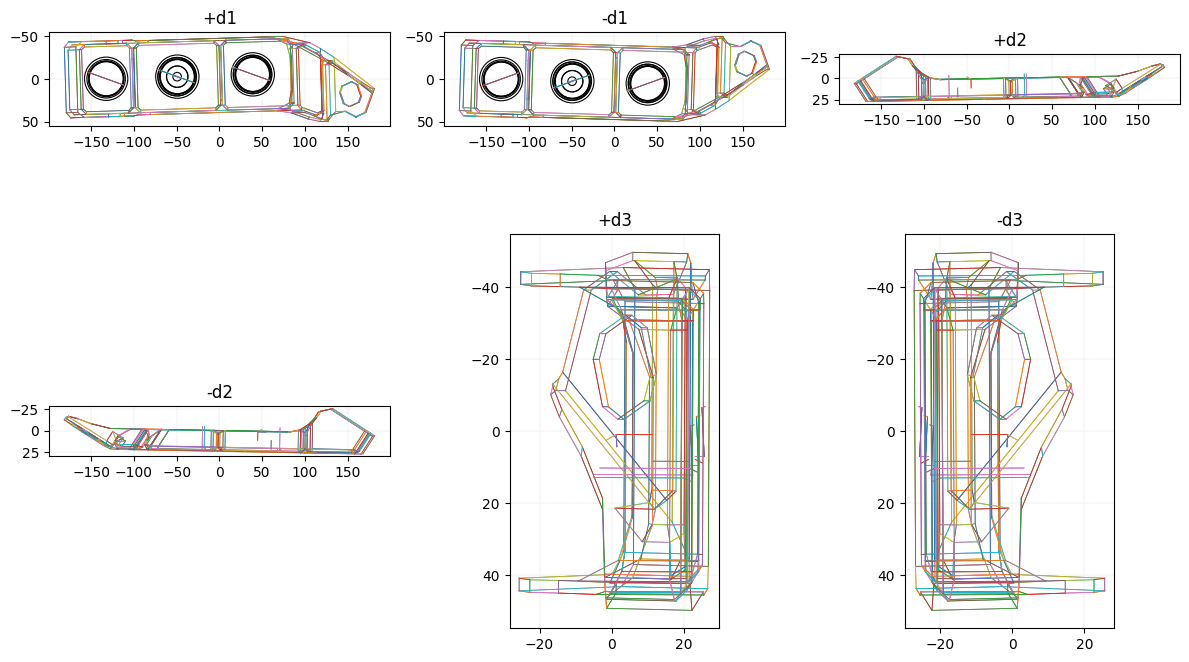

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (v, v_circles) in enumerate(zip(analytic_views, analytic_with_circles)):
    r, c = divmod(i, 3)
    ax = axes[r, c]
    plot_draft_view_edges_and_circles_and_rotation(ax, v_circles, title=v.name)

plt.tight_layout()
plt.show()

## смотрим на дуги отдельно

In [14]:
shape_raw = load_step("../data/example_complex.stp")
shape = extract_solids(shape_raw)

part_analysis = analyze_part(shape)
holes_afr = part_analysis.holes

views_6 = generate_six_obb_views(shape)  # твоя функция по OBB
vdef = views_6[0]  # например "+d1"

analytic_view = build_analytic_view_from_topology(shape, vdef.ax2, name=vdef.name)

from afr3d.drafting.circles import (
    rebuild_all_circles,
    add_arc_curves_from_topology,
)

view_with_circles = rebuild_all_circles(analytic_view, shape, holes_afr)

# Добавляем дуги поверх:
view_with_arcs = add_arc_curves_from_topology(view_with_circles, shape)


In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

from afr3d.drafting.model import DraftCurveKind

def plot_arcs_only(ax, view: DraftView2D, title: str = ""):
    angle = VIEW_ROTATION.get(view.name, 0)  # твоя таблица поворотов

    xs, ys = [], []

    for c in view.curves:
        if c.kind != DraftCurveKind.ARC:
            continue
        if not c.visible or c.center is None or c.radius is None:
            continue

        cx, cy = c.center
        cxr, cyr = rotate_point_deg(cx, cy, angle)  # твоя функция поворота
        R = c.radius

        # углы из радиан в градусы
        start_deg = math.degrees(c.start_angle or 0.0)
        end_deg = math.degrees(c.end_angle or 0.0)
        span_deg = end_deg - start_deg

        arc_patch = Arc(
            (cxr, cyr),
            2 * R, 2 * R,
            angle=0.0,
            theta1=start_deg,
            theta2=end_deg,
            linewidth=2.0,    # ЖИРНЫЕ
            linestyle="-",
        )
        ax.add_patch(arc_patch)

        xs.extend([cxr - R, cxr + R])
        ys.extend([cyr - R, cyr + R])

    if xs and ys:
        ax.set_xlim(min(xs), max(xs))
        ax.set_ylim(max(ys), min(ys))

    ax.set_aspect("equal", "box")
    ax.invert_yaxis()
    ax.set_title(title or f"{view.name} arcs")
    ax.grid(True, linestyle=":", linewidth=0.3)


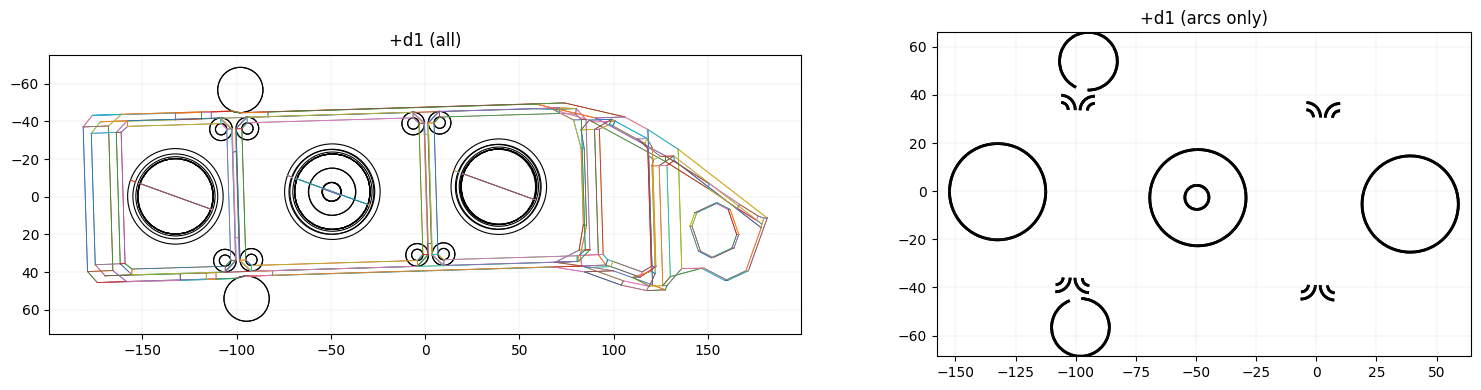

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# слева — привычный аналитический + окружности/отверстия
plot_draft_view_edges_and_circles(axes[0], view_with_arcs, title=f"{vdef.name} (all)")
# справа — только дуги (галтели и пр.)
plot_arcs_only(axes[1], view_with_arcs, title=f"{vdef.name} (arcs only)")

plt.tight_layout()
plt.show()
